#***LSTM***

#8:2

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Đọc dữ liệu từ file CSV
file_path = '/content/Bnb.csv'
data = pd.read_csv(file_path)

In [2]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 8:2
train_size = int(len(scaled_prices) * 0.8)
test_size = len(scaled_prices) - train_size

train, test = scaled_prices[0:train_size], scaled_prices[train_size:]

print(f'train: {train_size}')
print(f'test: {test_size}')

train: 1536
test: 384


In [3]:
# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# Dự đoán trên tập test
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Đánh giá mô hình
mse = mean_squared_error(y_test[0], test_predict[:,0])
mae = mean_absolute_error(y_test[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test[0] - test_predict[:,0]) / y_test[0])) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Epoch 1/50
1476/1476 - 48s - loss: 0.0033 - 48s/epoch - 32ms/step
Epoch 2/50
1476/1476 - 45s - loss: 0.0013 - 45s/epoch - 30ms/step
Epoch 3/50
1476/1476 - 44s - loss: 0.0011 - 44s/epoch - 30ms/step
Epoch 4/50
1476/1476 - 45s - loss: 9.8967e-04 - 45s/epoch - 30ms/step
Epoch 5/50
1476/1476 - 44s - loss: 7.7386e-04 - 44s/epoch - 30ms/step
Epoch 6/50
1476/1476 - 43s - loss: 8.0888e-04 - 43s/epoch - 29ms/step
Epoch 7/50
1476/1476 - 44s - loss: 7.5486e-04 - 44s/epoch - 30ms/step
Epoch 8/50
1476/1476 - 44s - loss: 7.3022e-04 - 44s/epoch - 30ms/step
Epoch 9/50
1476/1476 - 45s - loss: 7.1371e-04 - 45s/epoch - 31ms/step
Epoch 10/50
1476/1476 - 43s - loss: 6.6450e-04 - 43s/epoch - 29ms/step
Epoch 11/50
1476/1476 - 43s - loss: 7.6557e-04 - 43s/epoch - 29ms/step
Epoch 12/50
1476/1476 - 44s - loss: 6.7427e-04 - 44s/epoch - 30ms/step
Epoch 13/50
1476/1476 - 44s - loss: 6.5321e-04 - 44s/epoch - 30ms/step
Epoch 14/50
1476/1476 - 44s - loss: 6.3710e-04 - 44s/epoch - 30ms/step
Epoch 15/50
1476/1476 - 45s

In [4]:
# Dự đoán tương lai
def predict_future_lstm(model, initial_data, look_back, future_steps):
    predictions = []
    current_input = initial_data[-look_back:]

    for _ in range(future_steps):
        current_input = current_input.reshape((1, look_back, 1))
        next_pred = model.predict(current_input, verbose=0)
        predictions.append(next_pred[0, 0])
        current_input = np.concatenate((current_input[:, 1:, :], next_pred.reshape(1, 1, 1)), axis=1)

    return np.array(predictions)

# Dự đoán 30, 60 và 90 ngày
next_30_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 30)
next_60_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 60)
next_90_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 90)

# Biến đổi ngược dữ liệu để đưa về dạng giá trị ban đầu
next_30_days_actual = scaler.inverse_transform(next_30_days.reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(next_60_days.reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(next_90_days.reshape(-1, 1))

# In ra các dự đoán cho 30, 60 và 90 ngày tiếp theo
print("Predicted Prices for the Next 30 Days:")
print(next_30_days_actual.flatten())

print("\nPredicted Prices for the Next 60 Days:")
print(next_60_days_actual.flatten())

print("\nPredicted Prices for the Next 90 Days:")
print(next_90_days_actual.flatten())

Predicted Prices for the Next 30 Days:
[596.33246 594.18494 592.2033  589.85077 587.52655 585.27673 583.1458
 581.14874 579.28937 577.56537 575.97125 574.4999  573.14453 571.8979
 570.75305 569.7032  568.74194 567.8627  567.0596  566.3266  565.6582
 565.0492  564.49445 563.98956 563.52997 563.112   562.7317  562.3859
 562.0714  561.78546]

Predicted Prices for the Next 60 Days:
[596.33246 594.18494 592.2033  589.85077 587.52655 585.27673 583.1458
 581.14874 579.28937 577.56537 575.97125 574.4999  573.14453 571.8979
 570.75305 569.7032  568.74194 567.8627  567.0596  566.3266  565.6582
 565.0492  564.49445 563.98956 563.52997 563.112   562.7317  562.3859
 562.0714  561.78546 561.5254  561.28906 561.07404 560.87836 560.70074
 560.5391  560.3922  560.25854 560.1369  560.02625 559.92566 559.83405
 559.75073 559.675   559.606   559.54333 559.48615 559.4342  559.38684
 559.3439  559.30475 559.2691  559.2366  559.20703 559.1801  559.1557
 559.1334  559.11316 559.09467 559.0778 ]

Predicted Pri

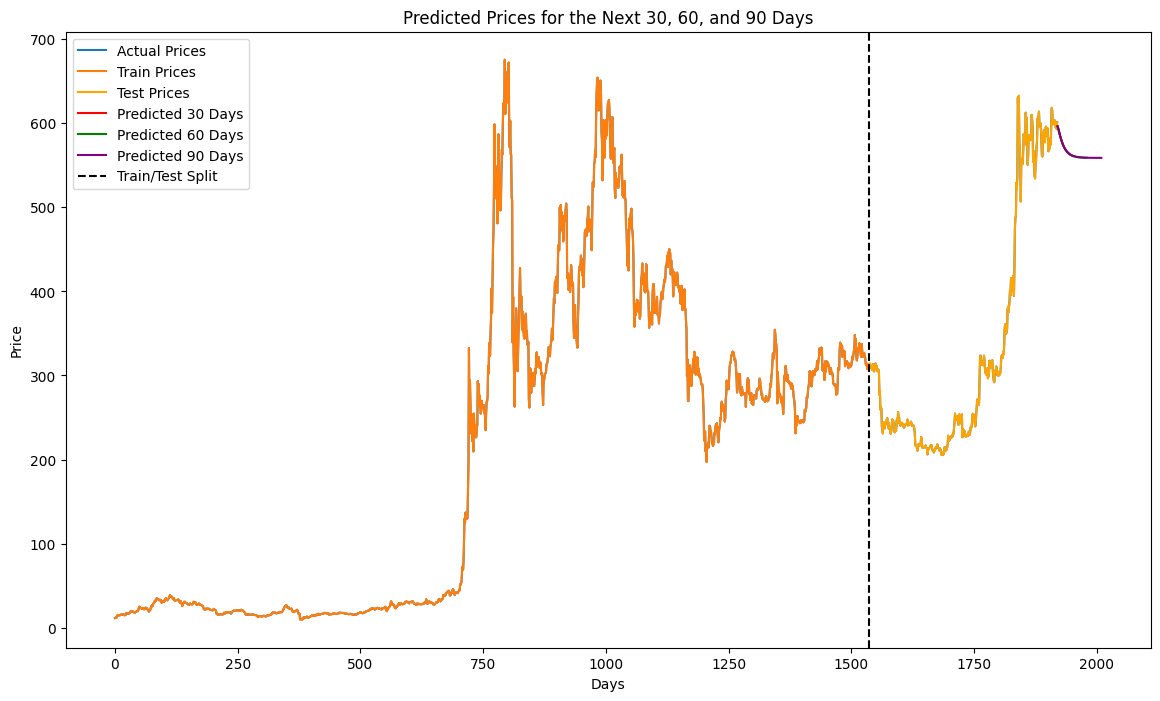

In [5]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()

#7:3

In [6]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 7:3
train_size = int(len(scaled_prices) * 0.7)
test_size = len(scaled_prices) - train_size

train, test = scaled_prices[0:train_size], scaled_prices[train_size:]

print(f'train: {train_size}')
print(f'test: {test_size}')

train: 1344
test: 576


In [7]:
# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# Dự đoán trên tập test
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Đánh giá mô hình
mse = mean_squared_error(y_test[0], test_predict[:,0])
mae = mean_absolute_error(y_test[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test[0] - test_predict[:,0]) / y_test[0])) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Epoch 1/50
1284/1284 - 43s - loss: 0.0036 - 43s/epoch - 34ms/step
Epoch 2/50
1284/1284 - 39s - loss: 0.0013 - 39s/epoch - 30ms/step
Epoch 3/50
1284/1284 - 39s - loss: 0.0011 - 39s/epoch - 30ms/step
Epoch 4/50
1284/1284 - 38s - loss: 0.0011 - 38s/epoch - 30ms/step
Epoch 5/50
1284/1284 - 39s - loss: 8.2474e-04 - 39s/epoch - 30ms/step
Epoch 6/50
1284/1284 - 41s - loss: 8.0019e-04 - 41s/epoch - 32ms/step
Epoch 7/50
1284/1284 - 39s - loss: 8.0979e-04 - 39s/epoch - 30ms/step
Epoch 8/50
1284/1284 - 50s - loss: 7.4208e-04 - 50s/epoch - 39ms/step
Epoch 9/50
1284/1284 - 38s - loss: 7.0477e-04 - 38s/epoch - 29ms/step
Epoch 10/50
1284/1284 - 39s - loss: 7.1784e-04 - 39s/epoch - 30ms/step
Epoch 11/50
1284/1284 - 40s - loss: 7.2970e-04 - 40s/epoch - 31ms/step
Epoch 12/50
1284/1284 - 40s - loss: 6.8440e-04 - 40s/epoch - 31ms/step
Epoch 13/50
1284/1284 - 39s - loss: 7.5199e-04 - 39s/epoch - 30ms/step
Epoch 14/50
1284/1284 - 39s - loss: 7.0810e-04 - 39s/epoch - 30ms/step
Epoch 15/50
1284/1284 - 38s - l

In [8]:
# Dự đoán tương lai
def predict_future_lstm(model, initial_data, look_back, future_steps):
    predictions = []
    current_input = initial_data[-look_back:]

    for _ in range(future_steps):
        current_input = current_input.reshape((1, look_back, 1))
        next_pred = model.predict(current_input, verbose=0)
        predictions.append(next_pred[0, 0])
        current_input = np.concatenate((current_input[:, 1:, :], next_pred.reshape(1, 1, 1)), axis=1)

    return np.array(predictions)

# Dự đoán 30, 60 và 90 ngày
next_30_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 30)
next_60_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 60)
next_90_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 90)

# Biến đổi ngược dữ liệu để đưa về dạng giá trị ban đầu
next_30_days_actual = scaler.inverse_transform(next_30_days.reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(next_60_days.reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(next_90_days.reshape(-1, 1))

# In ra các dự đoán cho 30, 60 và 90 ngày tiếp theo
print("Predicted Prices for the Next 30 Days:")
print(next_30_days_actual.flatten())

print("\nPredicted Prices for the Next 60 Days:")
print(next_60_days_actual.flatten())

print("\nPredicted Prices for the Next 90 Days:")
print(next_90_days_actual.flatten())

Predicted Prices for the Next 30 Days:
[591.0559  584.0153  577.07837 569.8047  562.9503  556.4862  550.32825
 544.3938  538.65967 533.1521  527.9202  523.0095  518.44653 514.2356
 510.36304 506.80438 503.5311  500.51566 497.7332  495.16245 492.78473
 490.5834  488.54318 486.65    484.89066 483.25314 481.72653 480.30118
 478.96826 477.7202 ]

Predicted Prices for the Next 60 Days:
[591.0559  584.0153  577.07837 569.8047  562.9503  556.4862  550.32825
 544.3938  538.65967 533.1521  527.9202  523.0095  518.44653 514.2356
 510.36304 506.80438 503.5311  500.51566 497.7332  495.16245 492.78473
 490.5834  488.54318 486.65    484.89066 483.25314 481.72653 480.30118
 478.96826 477.7202  476.5501  475.45187 474.41986 473.44916 472.53516
 471.67368 470.86108 470.09384 469.36896 468.68362 468.03513 467.42114
 466.83957 466.2882  465.76535 465.26932 464.79846 464.35114 463.92627
 463.52252 463.1386  462.7735  462.42612 462.09555 461.78085 461.4812
 461.19577 460.92392 460.66495 460.41806]

Predict

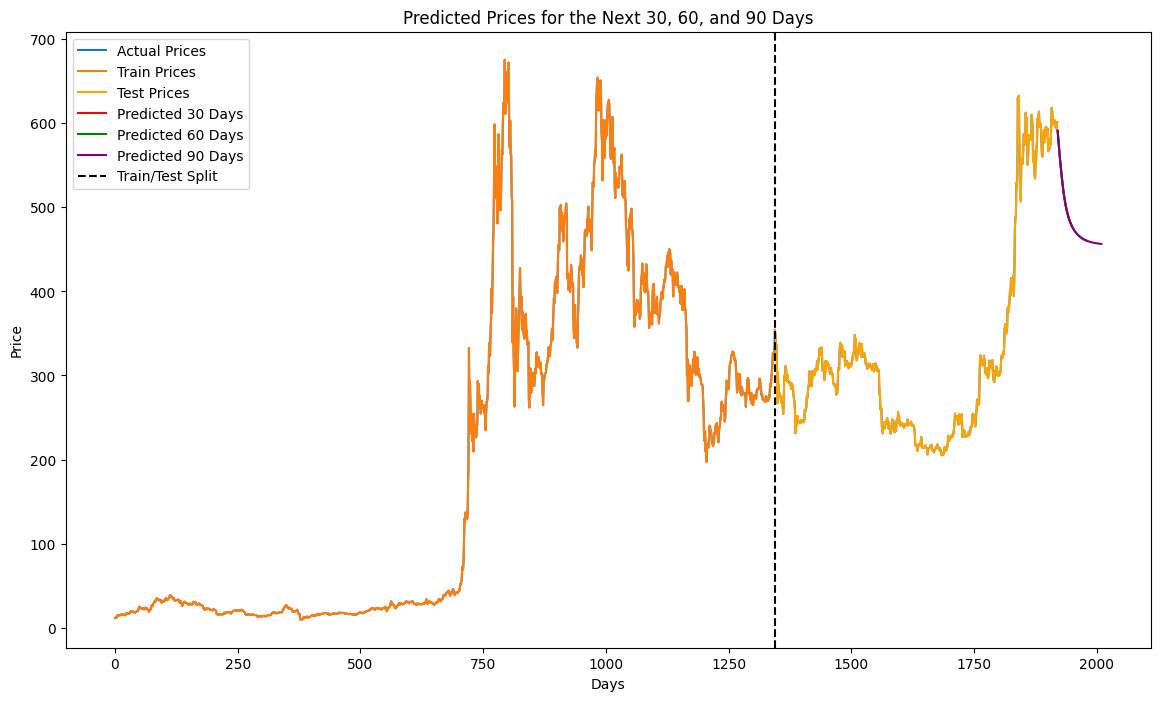

In [9]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()

#6:4

In [10]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 6:4
train_size = int(len(scaled_prices) * 0.6)
test_size = len(scaled_prices) - train_size

train, test = scaled_prices[0:train_size], scaled_prices[train_size:]

print(f'train: {train_size}')
print(f'test: {test_size}')

train: 1152
test: 768


In [11]:
# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# Dự đoán trên tập test
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Đánh giá mô hình
mse = mean_squared_error(y_test[0], test_predict[:,0])
mae = mean_absolute_error(y_test[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test[0] - test_predict[:,0]) / y_test[0])) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Epoch 1/50
1092/1092 - 37s - loss: 0.0043 - 37s/epoch - 34ms/step
Epoch 2/50
1092/1092 - 32s - loss: 0.0017 - 32s/epoch - 29ms/step
Epoch 3/50
1092/1092 - 34s - loss: 0.0014 - 34s/epoch - 31ms/step
Epoch 4/50
1092/1092 - 34s - loss: 0.0012 - 34s/epoch - 31ms/step
Epoch 5/50
1092/1092 - 33s - loss: 0.0010 - 33s/epoch - 30ms/step
Epoch 6/50
1092/1092 - 33s - loss: 9.3396e-04 - 33s/epoch - 30ms/step
Epoch 7/50
1092/1092 - 32s - loss: 8.1899e-04 - 32s/epoch - 30ms/step
Epoch 8/50
1092/1092 - 33s - loss: 8.6614e-04 - 33s/epoch - 31ms/step
Epoch 9/50
1092/1092 - 32s - loss: 9.7311e-04 - 32s/epoch - 29ms/step
Epoch 10/50
1092/1092 - 32s - loss: 8.3745e-04 - 32s/epoch - 30ms/step
Epoch 11/50
1092/1092 - 34s - loss: 8.1477e-04 - 34s/epoch - 31ms/step
Epoch 12/50
1092/1092 - 34s - loss: 8.7799e-04 - 34s/epoch - 31ms/step
Epoch 13/50
1092/1092 - 34s - loss: 8.0941e-04 - 34s/epoch - 31ms/step
Epoch 14/50
1092/1092 - 32s - loss: 8.0691e-04 - 32s/epoch - 29ms/step
Epoch 15/50
1092/1092 - 32s - loss:

In [12]:
# Dự đoán tương lai
def predict_future_lstm(model, initial_data, look_back, future_steps):
    predictions = []
    current_input = initial_data[-look_back:]

    for _ in range(future_steps):
        current_input = current_input.reshape((1, look_back, 1))
        next_pred = model.predict(current_input, verbose=0)
        predictions.append(next_pred[0, 0])
        current_input = np.concatenate((current_input[:, 1:, :], next_pred.reshape(1, 1, 1)), axis=1)

    return np.array(predictions)

# Dự đoán 30, 60 và 90 ngày
next_30_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 30)
next_60_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 60)
next_90_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 90)

# Biến đổi ngược dữ liệu để đưa về dạng giá trị ban đầu
next_30_days_actual = scaler.inverse_transform(next_30_days.reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(next_60_days.reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(next_90_days.reshape(-1, 1))

# In ra các dự đoán cho 30, 60 và 90 ngày tiếp theo
print("Predicted Prices for the Next 30 Days:")
print(next_30_days_actual.flatten())

print("\nPredicted Prices for the Next 60 Days:")
print(next_60_days_actual.flatten())

print("\nPredicted Prices for the Next 90 Days:")
print(next_90_days_actual.flatten())

Predicted Prices for the Next 30 Days:
[588.0306  579.2511  569.98267 559.99896 550.04675 540.3929  531.2066
 522.58704 514.5969  507.27545 500.64462 494.71048 489.46323 484.87842
 480.91873 477.53745 474.6819  472.29697 470.32803 468.72314 467.43408
 466.41708 465.63272 465.04556 464.6245  464.34198 464.1736  464.0985
 464.0983  464.1574 ]

Predicted Prices for the Next 60 Days:
[588.0306  579.2511  569.98267 559.99896 550.04675 540.3929  531.2066
 522.58704 514.5969  507.27545 500.64462 494.71048 489.46323 484.87842
 480.91873 477.53745 474.6819  472.29697 470.32803 468.72314 467.43408
 466.41708 465.63272 465.04556 464.6245  464.34198 464.1736  464.0985
 464.0983  464.1574  464.26248 464.40237 464.56757 464.7502  464.9439
 465.14316 465.34366 465.54208 465.73566 465.92236 466.10056 466.26926
 466.4278  466.57568 466.7128  466.83923 466.95514 467.06085 467.1567
 467.2433  467.32114 467.39072 467.4528  467.50778 467.55634 467.59894
 467.63623 467.66864 467.6966  467.72073]

Predicted 

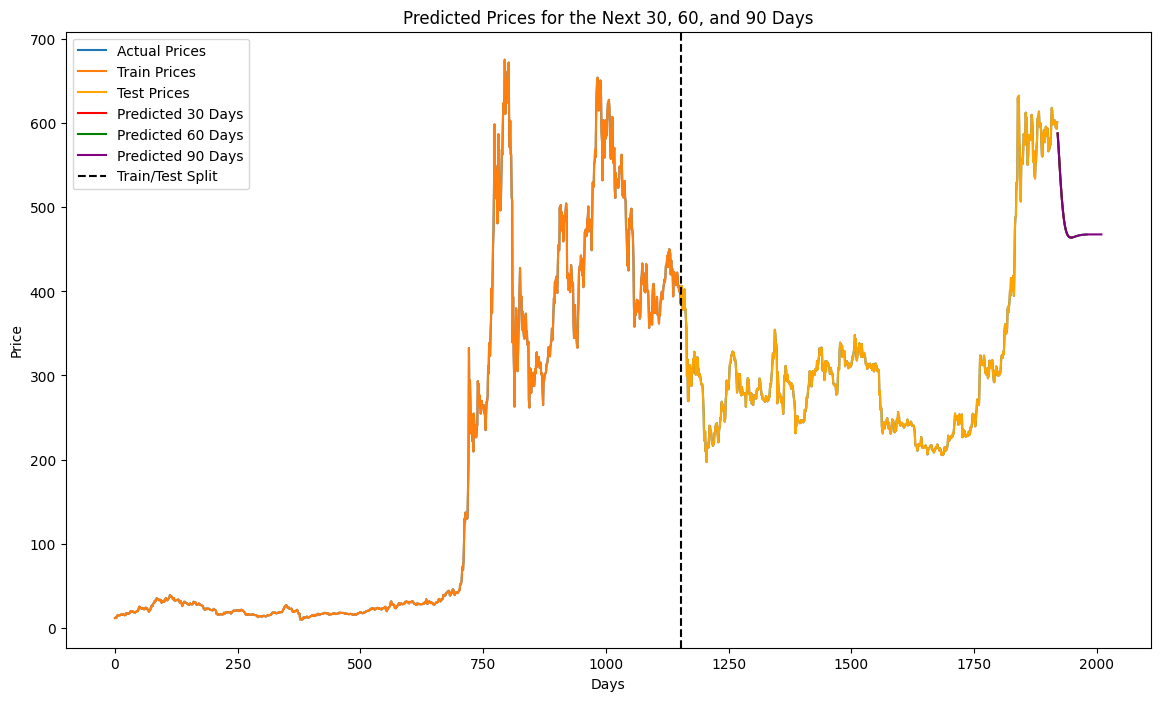

In [13]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()